### Import Libraries

In [1]:
# general nlp ibraries
import numpy as np
import pandas as pd
import re # for regular expressions
import matplotlib.pyplot as plt
import seaborn as sns
import string # string functions
import nltk # natural language tool kit
# sklearn librearies
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score # related to precission and recall

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = DeprecationWarning)

## Load Data

In [4]:
# import datasets
data = pd.read_csv("./data/sentiment.tsv",sep = '\t')
# No col names are present so, give your own
data.columns = ["label", "body_text"]

In [5]:
data.head()

,label,body_text
0,pos,having a vodka tonic and looking forward to go...
1,pos,@ddlovatofans1neg1 Could you follow me please....
2,pos,@jordanknight for once.................. PLEAS...
3,neg,Had a dream about a walk in fast food resturau...
4,pos,@TroyBrownBBNews Yes... For a &quot;friend&quot;


In [6]:
# label col must be one hot encoded
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data['label'] = le.fit_transform(data['label'])
data.head()

# 1 --> Positive
# 0 --> Negative

,label,body_text
0,1,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....
2,1,@jordanknight for once.................. PLEAS...
3,0,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;


## Clean Data

In [7]:
# helper function to remove twitter handles
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text) # retuns a list with substrings with 'pattern'
    for i in r:
        input_text = re.sub(i, "", input_text) # remove pattern 
    return input_text

In [8]:
# Remove twitter hadles
# ---------------------

# find pattern for twitter handles using regex
# @user
data['handle_removed'] = np.vectorize(remove_pattern)(data['body_text'], "@[\w]*")

# another way to write it
vecfunc = np.vectorize(remove_pattern)
data['handle_removed'] = vecfunc(data["body_text"], "@[\w]*")
# vecfunc works as :
#data['handle_removed'][0] = remove_pattern(data["body_text"][0], "@[\w]*")
#data['handle_removed'][1] = remove_pattern(data["body_text"][1], "@[\w]*")
#data['handle_removed'][2] = remove_pattern(data["body_text"][2], "@[\w]*")
#data['handle_removed'][3] = remove_pattern(data["body_text"][3], "@[\w]*")
#      .                           .
#      .                           .
#      .                           .

data.head()

,label,body_text,handle_removed
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please.I would really app...
2,1,@jordanknight for once.................. PLEAS...,for once.................. PLEASE TELL US WHY...
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes... For a &quot;friend&quot;


In [9]:
# Remove special characters (punctuations and punctuations)
# ---------------------------------------------------------

print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [10]:
# 1. convert pandas series to string
# 2. call replace method on string
# 3. Use regex to replace everything except [a-z] and [A-Z] with space (" ")
data['puncs_removed'] = data['handle_removed'].str.replace("[^a-zA-Z#]", " ")
# ^ : Not

data.head()

,label,body_text,handle_removed,puncs_removed
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please.I would really app...,Could you follow me please I would really app...
2,1,@jordanknight for once.................. PLEAS...,for once.................. PLEASE TELL US WHY...,for once PLEASE TELL US WHY...
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes... For a &quot;friend&quot;,Yes For a quot friend quot


## Tokenize

In [11]:
# having and have (or) looking and look are not that significantly different
# So, convert both to have or look
# This process is called `STEMMING`

# Tokenize before stemming. 
# Tokenize: Split into particular words i.e into list
tokenized_tweet = data['puncs_removed'].apply(lambda x: x.split())

tokenized_tweet.head()

0    [having, a, vodka, tonic, and, looking, forwar...
1    [Could, you, follow, me, please, I, would, rea...
2    [for, once, PLEASE, TELL, US, WHY, u, were, th...
3    [Had, a, dream, about, a, walk, in, fast, food...
4                    [Yes, For, a, quot, friend, quot]
Name: puncs_removed, dtype: object

In [12]:
# Stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()

# Iterate over every word in each list 
# So that `having` and `have` both can be converted into `have`
stemmed_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

stemmed_tweet.head()

0    [have, a, vodka, tonic, and, look, forward, to...
1    [could, you, follow, me, pleas, I, would, real...
2    [for, onc, pleas, tell, US, whi, u, were, thin...
3    [had, a, dream, about, a, walk, in, fast, food...
4                     [ye, for, a, quot, friend, quot]
Name: puncs_removed, dtype: object

In [13]:
# convert list of words into a line
for i in range(len(stemmed_tweet)):
    stemmed_tweet[i] = ' '.join(stemmed_tweet[i])

data["stemmed_tweet"] = stemmed_tweet
data.head()

,label,body_text,handle_removed,puncs_removed,stemmed_tweet
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...,have a vodka tonic and look forward to go to s...
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please.I would really app...,Could you follow me please I would really app...,could you follow me pleas I would realli appre...
2,1,@jordanknight for once.................. PLEAS...,for once.................. PLEASE TELL US WHY...,for once PLEASE TELL US WHY...,for onc pleas tell US whi u were think of thi ...
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes... For a &quot;friend&quot;,Yes For a quot friend quot,ye for a quot friend quot


## Add other column for length of the tweet and punctuation

- This will increase accuracy

In [14]:
def count_punc(text):
    num_puncs = sum([1 for char in text if char in string.punctuation])
    num_all = len(text) - text.count(" ")
    percent_of_puncs = round( (num_puncs / num_all), 3) * 100
    return percent_of_puncs

In [15]:
# add length column for original body
data['body_len'] = data["body_text"].apply(lambda x: len(x) - x.count(" ")) 

# add `percent_of_puncs` col
data['punc%'] = data["body_text"].apply(lambda x: count_punc(x))

data.head()

,label,body_text,handle_removed,puncs_removed,stemmed_tweet,body_len,punc%
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...,have a vodka tonic and look forward to go to s...,92,1.1
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please.I would really app...,Could you follow me please I would really app...,could you follow me pleas I would realli appre...,66,4.5
2,1,@jordanknight for once.................. PLEAS...,for once.................. PLEASE TELL US WHY...,for once PLEASE TELL US WHY...,for onc pleas tell US whi u were think of thi ...,81,27.2
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...,96,1.0
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes... For a &quot;friend&quot;,Yes For a quot friend quot,ye for a quot friend quot,44,18.2


## Generate word cloud 

- See how many and what many words are available in our data

In [16]:
# join all rows into one line
all_words = ' '.join([text for text in data['stemmed_tweet']])
all_words

'have a vodka tonic and look forward to go to saddl ranch at the westgat with the husband san kiddo could you follow me pleas I would realli appreci it for onc pleas tell US whi u were think of thi person had a dream about a walk in fast food resturaunt that sold ice cream and guitar string they were sold out of gaug ye for a quot friend quot pack for work expier hate angri angri but no choic http plurk com p rqqi I said I go out for eat negneg p m I disappoint you yeah they won t do the surgeri till the cold is gone poor thing still ha runni eye I say answer with no pant Am in the place call negut OF now where take me out from here somebodi http myloc me xri am still up fli to LA ltr am hayyy sleep depriv again down to go look like i wont be get out earli It s increibl how someon forgot U soo fast that littl girl holli find some time Aw she ll get load of vote now I bet aapko huyi asuvidha ke liy hume khed hay train neg minut late ugh me too po and go strong I just spent like hour pla

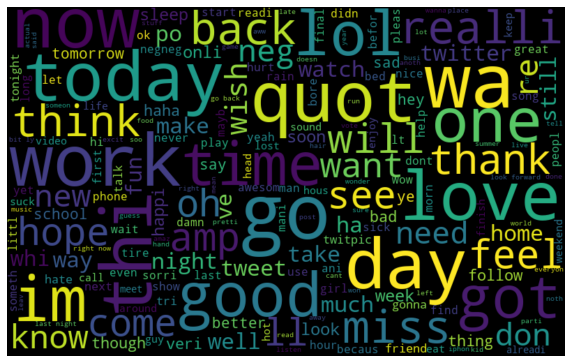

In [17]:
# create word cloud using canvas
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, 
                      height=500, 
                      random_state=21,
                      max_font_size=110
                     ).generate(all_words)

plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Wordcloud for negative tweet

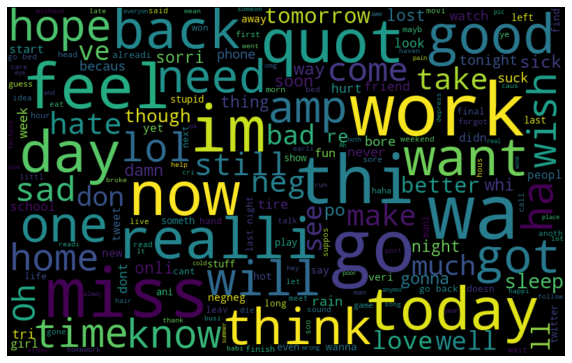

In [18]:
# collect negative tweets. All in one line
neg_tweets = ' '.join([text for text in data['stemmed_tweet'][data['label'] == 0] ])

wordcloud = WordCloud(width=800, 
                      height=500, 
                      random_state=21,
                      max_font_size=110
                     ).generate(neg_tweets)

plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Encode the data into numeric form

### Two types: 
    
    - Count Vectorizer
    - Tfidf Vectorizer

In [19]:
# COUNT VECTORIZER
# -------------------------------------
# Counts number of occurances in a row.

from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(stop_words='english')

#transform
bow = bow_vectorizer.fit_transform(data['stemmed_tweet'])
type(bow)
# Note: `bow` is of type scipy.sparse.csr.csr_matrix

scipy.sparse.csr.csr_matrix

In [20]:
X_features_countvec = pd.concat([
                    data['body_len'],
                    data['punc%'],
                    pd.DataFrame(bow.toarray())
              ], axis = 1)

X_features_countvec.head()

,body_len,punc%,0,1,2,3,4,5,6,7,...,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943
0,92,1.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66,4.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,81,27.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,96,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44,18.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Tfidf VECTORIZER
# ------------------------------------------------------
# How much uniformly a word is distributed in doccument
# Sometime better but not always.

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = "english")

# transform
tfidf = tfidf_vectorizer.fit_transform(data["stemmed_tweet"])

X_features_tfidfvec = pd.concat([
                    data['body_len'],
                    data['punc%'],
                    pd.DataFrame(bow.toarray())
              ], axis = 1)

X_features_tfidfvec.head()

,body_len,punc%,0,1,2,3,4,5,6,7,...,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943
0,92,1.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66,4.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,81,27.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,96,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44,18.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TEST ALL CASSIFICATION ALGORITHMS

In [20]:
# Different classiication algorithms
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# for accuracy check
from sklearn.model_selection import cross_val_score

In [25]:
# To iterate and test create list
model = []
model.append( ('RF', RandomForestClassifier()) )
model.append( ('GB', GradientBoostingClassifier()) )
model.append( ('DT', DecisionTreeClassifier()) )
model.append( ('NB', GaussianNB()) )
model.append( ('LR', LogisticRegression()) )
model.append( ('KNN', KNeighborsClassifier()) )
model.append( ('SVC', SVC()) )

## Ten-Fold Cross-Validation (Count Vectorizer)

In [22]:
for model, classifier in model:
    scores = cross_val_score(
                    classifier, 
                    X_features_countvec, 
                    data['label'], 
                    scoring = 'accuracy', 
                    cv=10)
    
    print("Model: {}, Accuracy: {}".format(model, scores.mean()))

/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Model: LR, Accuracy: 0.6695000000000001
Model: RF, Accuracy: 0.659
Model: GB, Accuracy: 0.6489999999999999
Model: DT, Accuracy: 0.5965
Model: NB, Accuracy: 0.5984999999999999


/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Model: LR, Accuracy: 0.6695000000000001
Model: KNN, Accuracy: 0.502
Model: SVC, Accuracy: 0.4915000000000001


## Ten-Fold Cross-Validation (Tfidf Vectorizer)

In [26]:
for model, classifier in model:
    scores = cross_val_score(
                    classifier, 
                    X_features_tfidfvec, 
                    data['label'], 
                    scoring = 'accuracy', 
                    cv=10)
    
    print("Model: {}, Accuracy: {}".format(model, scores.mean()))

Model: RF, Accuracy: 0.666
Model: GB, Accuracy: 0.6455000000000001
Model: DT, Accuracy: 0.6050000000000001
Model: NB, Accuracy: 0.5984999999999999


/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Model: LR, Accuracy: 0.6695000000000001
Model: KNN, Accuracy: 0.502
Model: SVC, Accuracy: 0.4915000000000001


# Parameter tuning for the best model

In [27]:
# Logistic regression gives highest accuracy

# Hyperparameter tuning
param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(
            LogisticRegression(),
            param_grid,
            cv = 10)
grid.fit(X_features_countvec, data['label'])

/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None, param_grid={'C': [0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [28]:
grid.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

scores = cross_val_score(
                model,
                X_features_countvec,
                data['label'],
                scoring='accuracy',
                cv=10)

print(scores.mean())

/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

0.6900000000000001


/Users/mac/Desktop/github/applied-ml/Applied-Machine-Learning/Resources/04-NLP-Deployment-Flask/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [30]:
# can do the same to X_features_tfidfvec

In [31]:
# You could perform the same after performing 
# test-train split using sklearn
# Instead of using cross validation

X_train, X_test, y_train, y_test = train_test_split(X_features_countvec, data['label'], test_size=0.33, random_state=42)

In [33]:
# Define model
model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
# Train
model.fit(X_train, y_train)

# predict
pred = model.predict(X_test)
pred

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score

# check acc.
accuracy_score(pred, y_test)

0.6772727272727272

In [37]:
# confusion matrix
confusion_matrix(y_test, pred)

array([[217,  96],
       [117, 230]])